In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derivative(y,t):
    return torch.autograd.grad(
        y,t,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True
    )[0]

In [3]:
class Sin(nn.Module):
    def forward(self,x):
        return torch.sin(x)

In [4]:
#Model
class PINN(nn.Module):
    def __init__(self,hidden_dim=40,hidden_layers=3):
        super(PINN, self).__init__()
        layers=[]
        layers.append(nn.Linear(1,hidden_dim))
        layers.append(Sin())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(Sin())
        layers.append(nn.Linear(hidden_dim,1))
        self.net=nn.Sequential(*layers)
    def forward(self,t):
        return self.net(t)

In [5]:
#True_solution
def true_solution(t,x0=1.0,v0=0.0,omega=2.0):
    return x0*np.cos(omega*t)+(v0/omega)*np.sin(omega*t)
omega=2.0
x0,v0=1.0,0.0
t_min,t_max=0.0,5*np.pi/omega
device=torch.device("cpu")

In [6]:
#Data_generation
np.random.seed(0)
N_data=50
t_data_np=np.linspace(t_min,t_max,N_data)
x_exact=true_solution(t_data_np,x0,v0,omega)
noise=0.9*np.random.randn(*x_exact.shape)
x_noisy=x_exact+noise

t_data=torch.tensor(t_data_np.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
x_data=torch.tensor(x_noisy.reshape(-1, 1), dtype=torch.float32)

# 5. Generate collocation points for physics loss
N_f=1000
t_f=torch.linspace(t_min, t_max, N_f).view(-1, 1).requires_grad_(True)

In [7]:
model=PINN()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_fn():
    #Data_loss
    x_pred_data=model(t_data)
    loss_data=torch.mean((x_pred_data - x_data)**2)
    #Physics_loss
    x_pred_f=model(t_f)
    dx_dt_f=derivative(x_pred_f, t_f)
    d2x_dt2_f=derivative(dx_dt_f, t_f)
    residual=d2x_dt2_f + omega**2 * x_pred_f
    loss_phys=torch.mean(residual**2)

    return loss_data + loss_phys, loss_data.item(), loss_phys.item()



In [8]:
losses,data_losses,phys_losses=[],[],[]
for epoch in range(10000):
    optimizer.zero_grad()
    loss, l_data, l_phys=loss_fn()
    loss.backward()
    optimizer.step()
    if epoch%2000==0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.2e}, Data: {l_data:.2e}, Phys: {l_phys:.2e}")
        losses.append(loss.item())
        data_losses.append(l_data)
        phys_losses.append(l_phys)



Epoch 0, Total Loss: 1.58e+00, Data: 1.51e+00, Phys: 7.34e-02
Epoch 2000, Total Loss: 1.02e+00, Data: 9.93e-01, Phys: 2.34e-02
Epoch 4000, Total Loss: 1.02e+00, Data: 9.94e-01, Phys: 2.12e-02
Epoch 6000, Total Loss: 1.02e+00, Data: 9.94e-01, Phys: 2.12e-02
Epoch 8000, Total Loss: 1.02e+00, Data: 9.94e-01, Phys: 2.22e-02


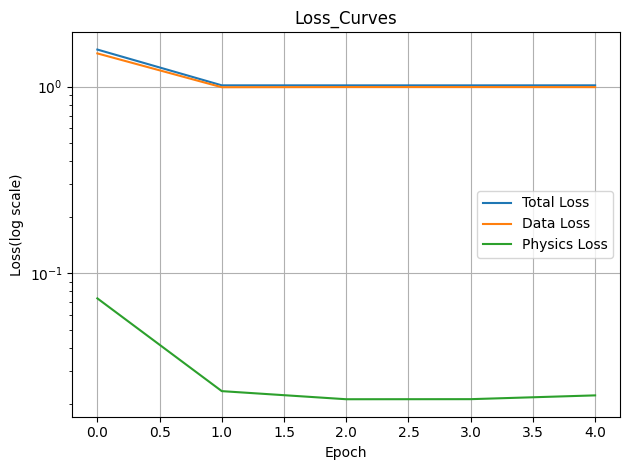

In [9]:
plt.plot(np.array(losses),label="Total Loss")
plt.plot(np.array(data_losses),label="Data Loss")
plt.plot(np.array(phys_losses),label="Physics Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss(log scale)")
plt.title("Loss_Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

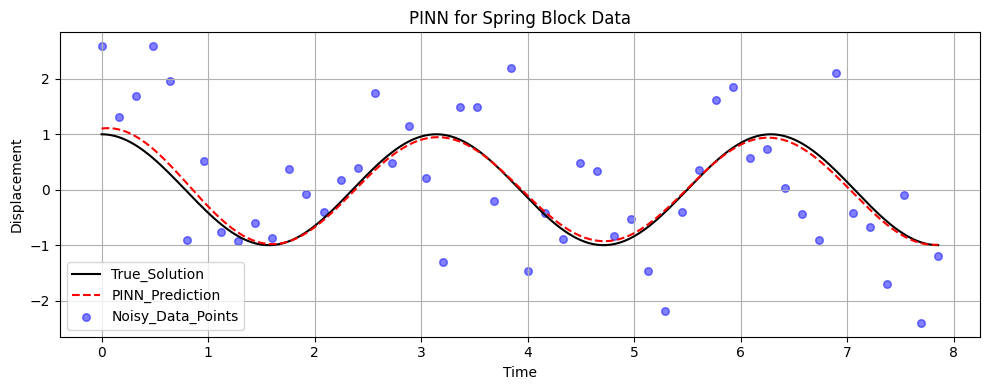

In [10]:
#Evaluation
t_test = torch.linspace(t_min, t_max, 200).view(-1,1).requires_grad_(True)
x_pred = model(t_test).detach().numpy()
x_true = true_solution(t_test.detach().numpy().flatten(), x0, v0, omega)

plt.figure(figsize=(10,4))
plt.plot(t_test.detach(),x_true,'k-',label="True_Solution")
plt.plot(t_test.detach(),x_pred,'r--',label="PINN_Prediction")
plt.scatter(t_data.detach(),x_data.detach(),c='blue',label="Noisy_Data_Points",s=30,alpha=0.5)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.title("PINN for Spring Block Data")
plt.grid(True)
plt.tight_layout()
plt.show()